# Sentiment Analysis

In [1]:
import pandas as pd
import zipfile
import os
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Ensure you have the necessary NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Step 1: Extract the dataset
zip_file_path = 'Social Media Sentiments.zip'
extraction_dir = 'extracted_files'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Files extracted successfully to {extraction_dir}")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while extracting the zip file: {e}")

# Define the path to the CSV file after extraction
csv_file_path = os.path.join(extraction_dir, 'sentimentdataset.csv')

Files extracted successfully to extracted_files


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Step 2: Load the dataset
try:
    data = pd.read_csv(csv_file_path)
    print("\nData loaded successfully. First few rows:")
    print(data.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")


Data loaded successfully. First few rows:
   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                        

In [4]:
# Step 3: Clean the text column
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

data['Cleaned_Text'] = data['Text'].apply(lambda x: clean_text(str(x)))

In [5]:
# Step 4: Enhanced Label Simplification with Debugging
def simplify_sentiment_debug(sentiment):
    """Simplifies sentiment categories with debug output."""
    positive_sentiments = ['Joy', 'Excitement', 'Contentment', 'Happiness', 'Admiration', 'Gratitude']
    negative_sentiments = ['Sadness', 'Anger', 'Fear', 'Frustration', 'Disgust', 'Betrayal']
    neutral_sentiments = ['Neutral', 'Calmness']

    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    elif sentiment in neutral_sentiments:
        return 'Neutral'
    else:
        return 'Other'

# Apply the simplification function
data['Simplified_Sentiment'] = data['Sentiment'].apply(simplify_sentiment_debug)

# Inspect the label distribution
print("\nOriginal Sentiment Distribution:")
print(data['Sentiment'].value_counts())

print("\nSimplified Sentiment Distribution:")
print(data['Simplified_Sentiment'].value_counts())

# Step 6: Train-Test Split with Stratification
X = data['Cleaned_Text']
y = data['Simplified_Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify label distribution in train and test sets
print("\nLabel distribution in y_train:")
print(y_train.value_counts())

print("\nLabel distribution in y_test:")
print(y_test.value_counts())

# If the data is still imbalanced or contains only one label, print a warning
if len(y_train.unique()) < 2:
    print("\nWarning: Training data contains only one unique class.")
    print("Consider revising the label simplification logic or rebalancing the dataset.")

# Step 7: Convert Text to TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 8: Train Logistic Regression Model (if multiple classes exist)
if len(y_train.unique()) > 1:
    model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    model.fit(X_train_tfidf, y_train)

    # Step 9: Evaluate the Model
    y_pred = model.predict(X_test_tfidf)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nAccuracy Score:")
    print(accuracy_score(y_test, y_pred))
else:
    print("\nUnable to train the Logistic Regression model due to insufficient class diversity.")
    model = None  # Explicitly set model to None

# Save the model and vectorizer if the model is trained
if model:
    with open('sentiment_model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)
    print("Model saved successfully!")

    with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
        pickle.dump(tfidf_vectorizer, vectorizer_file)
    print("Vectorizer saved successfully!")
else:
    print("Model training was skipped. No files were saved.")


Original Sentiment Distribution:
Sentiment
Positive           44
Joy                42
Excitement         32
Neutral            14
Contentment        14
                   ..
Adrenaline          1
Harmony             1
ArtisticBurst       1
Radiance            1
Elegance            1
Name: count, Length: 279, dtype: int64

Simplified Sentiment Distribution:
Simplified_Sentiment
Other    732
Name: count, dtype: int64

Label distribution in y_train:
Simplified_Sentiment
Other    585
Name: count, dtype: int64

Label distribution in y_test:
Simplified_Sentiment
Other    147
Name: count, dtype: int64

Consider revising the label simplification logic or rebalancing the dataset.

Unable to train the Logistic Regression model due to insufficient class diversity.


C:\Users\milto\AppData\Local\Temp\ipykernel_7540\1676623438.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Sentiment', data=data, order=data['Sentiment'].value_counts().index, palette='viridis')


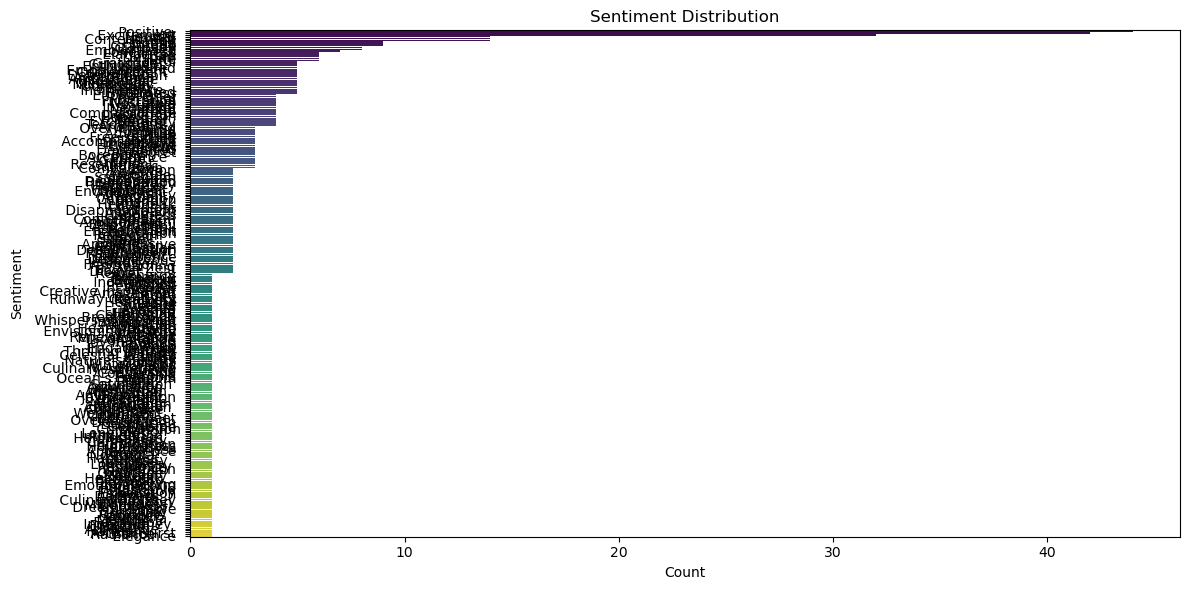


Number of missing timestamps: 0


C:\Users\milto\AppData\Local\Temp\ipykernel_7540\1676623438.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sentiment_trends, x='Timestamp', y='Counts', hue='Sentiment', marker='o', ci=None, palette='tab10')
C:\Users\milto\AppData\Local\Temp\ipykernel_7540\1676623438.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\milto\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


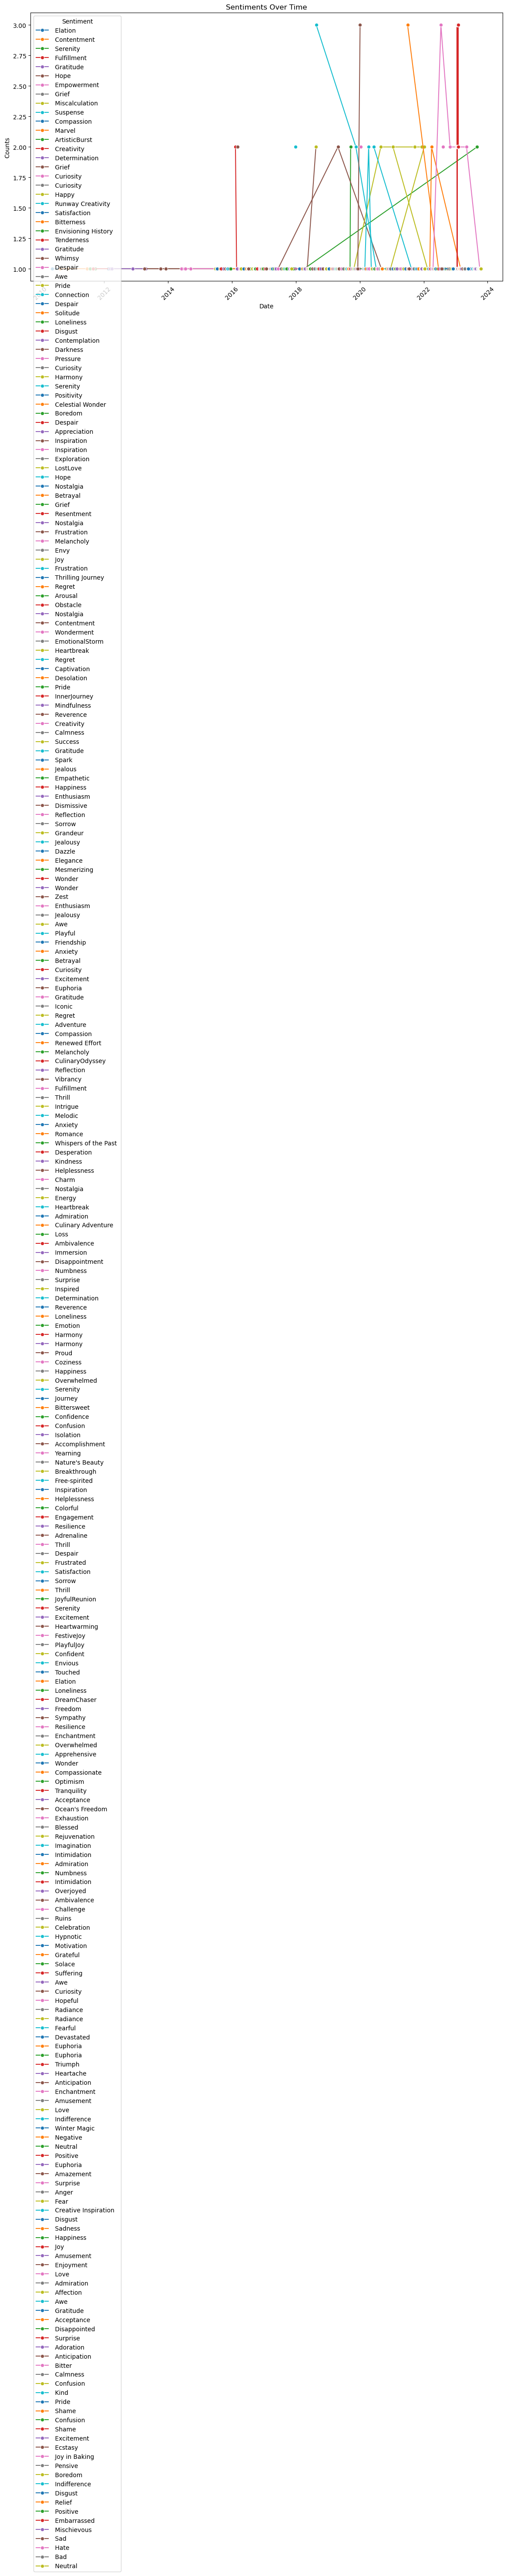

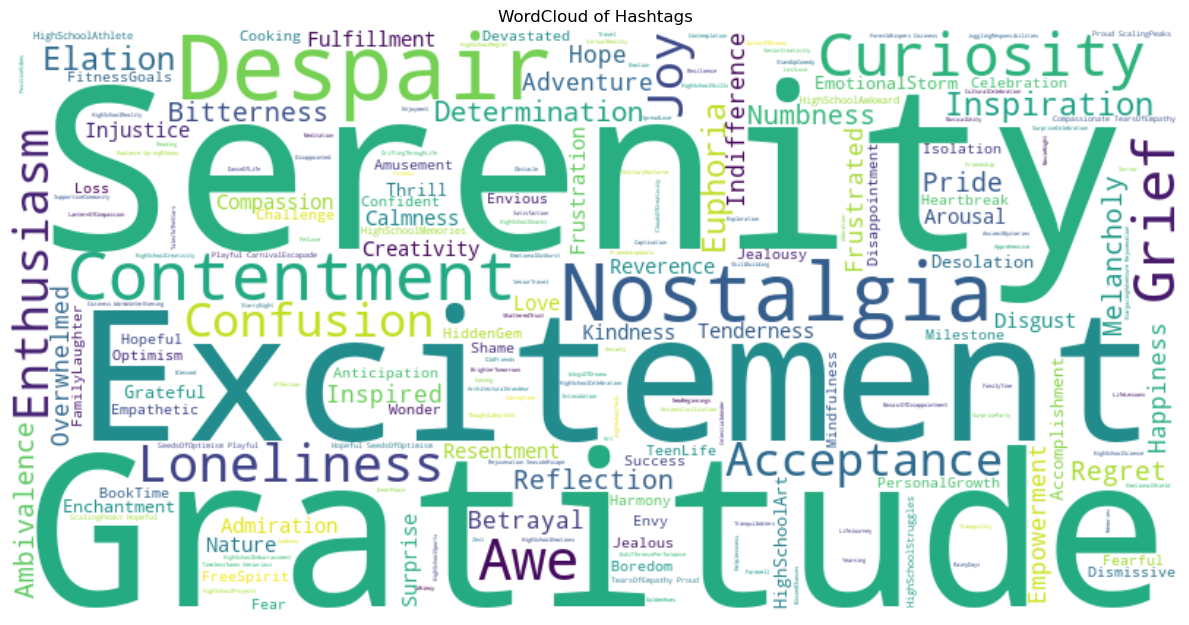

In [6]:
# Explore Sentiment Trends

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Sentiment', data=data, order=data['Sentiment'].value_counts().index, palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.tight_layout()
plt.show()

# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Check for missing or invalid timestamps
print("\nNumber of missing timestamps:", data['Timestamp'].isnull().sum())

# Filter out rows with invalid timestamps
data = data.dropna(subset=['Timestamp'])

# Aggregate sentiment counts over time
sentiment_trends = data.groupby([data['Timestamp'].dt.date, 'Sentiment']).size().reset_index(name='Counts')

# Sentiments Over Time
plt.figure(figsize=(14, 8))
sns.lineplot(data=sentiment_trends, x='Timestamp', y='Counts', hue='Sentiment', marker='o', ci=None, palette='tab10')
plt.title("Sentiments Over Time")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate a WordCloud for Hashtags
hashtags = ' '.join(data['Hashtags'].dropna().values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hashtags)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Hashtags")
plt.tight_layout()
plt.show()
